In [10]:
import csv
import os
import numpy
import matplotlib.pyplot as plt
import statistics
from scipy.stats import pearsonr, ttest_ind, norm, median_absolute_deviation, ttest_ind
from statsmodels import robust
import math
import pandas as pd
import json

plt.rcParams.update({'font.size': 18})

In [2]:
def get_weighted_median(msd, msd_std, num_trials = 10000):
    msd = numpy.array(msd)
    msd_std = numpy.array(msd_std)
    
    #print(type(msd[0]))
    #print(type(msd_std[0]))
    weights = 1/msd_std**2
    norm_weights = weights/numpy.sum(weights)
    
    rvs = numpy.random.choice(msd, size = num_trials, p = norm_weights)
    weighted_median = statistics.median(rvs)
    weighted_mad = statistics.median(abs(rvs-weighted_median))

    return weighted_median, weighted_mad

In [3]:
def draw_random_sets(num_draws, n, msd_genes, msd_std_genes):
    # This function draws random sets of msd values without replacement
    choice = numpy.random.choice
    
    msd_all = numpy.empty((num_draws, n))
    msd_all.fill('nan')
    msd_std_all = numpy.empty((num_draws, n))
    msd_std_all.fill('nan')
        
    # Draw num_draws sets of draws
    for j in range(num_draws):
        # Select n MSD values at random from all KO MSD values (or WT values) (where n = number of genes with that GO term)
            inds = choice(range(len(msd_genes)), size=n, replace=True)
            msd_all[j,:] = msd_genes[inds]
            msd_std_all[j,:] = msd_std_genes[inds]

    return msd_all, msd_std_all

def draw_random_sets_gaussian(num_draws, n, mean, std):
    # This function draws random sets of msd values without replacement
    
    msd_all = numpy.empty((num_draws, n))
    msd_all.fill('nan')
        
    # Draw num_draws sets of draws
    # Select n MSD values at random from all KO MSD values (or WT values) (where n = number of genes with that GO term)
    msd_all = numpy.random.normal(loc = mean, scale = std, size = (num_draws,n))
    msd_std_all = numpy.ones(msd_all.shape)*0.01
    # Write code for mean var relationship of msd and msd ste
    
    return msd_all, msd_std_all


def calc_wmean(values, errors, axis = 1):
    wmean = numpy.average(values, weights = 1/(errors**2), axis = axis)
    wmean_ste = numpy.sqrt(1/(numpy.sum(1/(errors)**2, axis = axis)))
    return wmean, wmean_ste
def calc_mean(values, errors, axis = 1):
    mean = numpy.average(values, axis = axis)
    std = numpy.std(values, axis = axis)   # Change this one to ste, or above to std?
    return mean, std
def calc_median(values, errors, axis = 1):
    median = numpy.median(values, axis = axis)
    mad = median_absolute_deviation(values, axis = axis)
    return median, mad
def calc_wmedian(values, errors, axis = 1):
    if axis == 1:
        wmedian = numpy.empty(values.shape[0])
        wmedian.fill('nan')

        wmad = numpy.empty(values.shape[0])
        wmad.fill('nan')
        for i in range(values.shape[0]):
            wmedian[i], wmad[i] = get_weighted_median(values[i,:], errors[i,:], num_trials = 10000)
    elif axis == 0:
        wmedian, wmad = get_weighted_median(values, errors, num_trials = 100)
    return wmedian, wmad

def run_go(iteration_number, go_term, go_wmean, go_wmean_ste, fixed, all_average, calc_average, average_type, mean, std):
    # This function calculates the significance level for a given go term
    # by randomly drawing sets of MSD values (from KO or WT distribution), calculating median,
    # and calculating fraction of times that this is more extreme than the actual median msd for that go term
    
    # Inputs:
    # Set of actual MSD values for this go term and whether they are fixed or not
    # Set of MSDs to draw random values from

    actual_average, actual_error = calc_average(go_wmean, go_wmean_ste, axis = 0)
    
    n = len(go_wmean)
    n_fixed = numpy.count_nonzero(fixed)
    # Calculate the number of msd values that will be drawn randomly after subtracting the number of fixed msd values
    n_rand = n-n_fixed

    # Randomly draw num_draws sets of n msd (and error) values from msd_genes (msd_std_genes). 
    rand_wmean_all, rand_wmean_ste_all = draw_random_sets_gaussian(num_draws, n_rand, mean, std)
#     rand_wmean_all, rand_wmean_ste_all = draw_random_sets(num_draws, n_rand, rand_wmean_set, rand_wmean_ste_set)

    if n_fixed > 0:    
        fixed_ind = numpy.where(fixed)[0]
#         print(fixed_ind)

        fixed_wmean = go_wmean[fixed_ind]
        fixed_wmean_ste = go_wmean_ste[fixed_ind]

        rand_wmean_all_w_fixed = numpy.concatenate((rand_wmean_all, numpy.tile(fixed_wmean, (rand_wmean_all.shape[0],1))), axis = 1)
        rand_wmean_ste_all_w_fixed = numpy.concatenate((rand_wmean_ste_all, numpy.tile(fixed_wmean_ste, (rand_wmean_ste_all.shape[0],1))), axis = 1)
#         print(rand_wmean_all_w_fixed)
    else: 
        rand_wmean_all_w_fixed = rand_wmean_all
        rand_wmean_ste_all_w_fixed = rand_wmean_ste_all
    
    rand_average, rand_error = calc_average(rand_wmean_all_w_fixed, rand_wmean_ste_all_w_fixed)

#     statistic, pvalue = ttest_ind(go_wmean, numpy.transpose(rand_wmean_all), axis = 0, equal_var = False)
    


    # If the average random MSD value is more extreme than average actual MSD value, record it as a success
    # (More extreme = random less than actual if actual is less than average of overall distribution, more than actual if vice versa)
    if actual_average < all_average:
        draws_more_extreme = rand_average<=actual_average
    else:
        draws_more_extreme = rand_average>=actual_average
    average_p_value = numpy.sum(draws_more_extreme)/num_draws
    # Return the fraction of draws that are more extreme   
    
#     print('mean msd for go term = ' + str(numpy.mean(go_wmean)))
    
    plt.ioff
#     average_pvalue = numpy.mean(pvalue)
    h, b = numpy.histogram(go_wmean, density = True)
    b = b[:-1]+(b[1]-b[0])/2
    plt.plot(b, h, 'o-', alpha = 0.5, label = 'true')
    
    h, b = numpy.histogram(go_wmean, weights = 1/(go_wmean_ste**2), density = True)
    b = b[:-1]+(b[1]-b[0])/2
    plt.plot(b, h, 'o-', alpha = 0.5, label = 'weighted true')
    
    h, b = numpy.histogram(numpy.transpose(rand_average), density = True)
    b = b[:-1]+(b[1]-b[0])/2
    plt.plot(b, h, 'o-', alpha = 0.5, label = 'wt avg')
    
    plt.scatter(actual_average, 0, 200, c = 'tab:orange', marker = 'x', label = 'true avg')
    plt.scatter(all_average, 0, 200, c = 'k', marker = '+', label = 'all wt avg')
    
    plt.xlabel('MSD')
    plt.ylabel('prob')
    plt.title(go_term + '\n n = ' + str(n) + ', p = ' + str(round(average_p_value, 6)))
    
    plt.legend(loc = 'upper left')
    
    plt.xlim([0.3, 1.3])
    
#     plt.tight_layout()
        
    plt.savefig('/Users/qinqinyu/Documents/hallatschek_lab/data_changed/20200228_spatial_genetic_drift_summary/go_analysis/' + average_type + '_wt/output_figures/iteration' + str(iteration_number) + '/' + go_term + str(iteration_number) + '.pdf')
    

    
    plt.close()
#     plt.show()

    return average_p_value

In [4]:
# Import data as dataframe and get some general information

filename = '/Users/qinqinyu/Documents/hallatschek_lab/data_changed/20200228_spatial_genetic_drift_summary/all_exp_rel_wmean_replicated_msd_50um_go_terms.csv'
df = pd.read_csv(filename)
print(df.columns)

# Keep only DE1-4
df_de1234 = df[0:384]

# Non-wild type and non-nan
df = df_de1234[df_de1234['genotype'] != 'WT']

df.reset_index(drop = True, inplace = True)   # Resets the indices to count up from 0
df = df.dropna(subset = ['wmean'])

df.reset_index(drop = True, inplace = True)   # Resets the indices to count up from 0

# Wild type and non-nan
df_wt = df_de1234[df_de1234['genotype'] == 'WT']
df_wt = df_wt.dropna(subset = ['wmean'])
df_wt.reset_index(drop = True, inplace = True)   # Resets the indices to count up from 0

# Scramble MSD values
msd_before_scrambling = df['wmean'].values.astype('float')
msd_std_before_scrambling = df['wmean_ste'].values.astype('float')

ind_after_scrambling = numpy.random.choice(range(len(msd_before_scrambling)), size = len(msd_before_scrambling), replace = False)
msd_after_scrambling = msd_before_scrambling[ind_after_scrambling]
msd_std_after_scrambling = msd_std_before_scrambling[ind_after_scrambling]

df_scrambled = df.copy()
df_scrambled['wmean'] = msd_after_scrambling
df_scrambled['wmean_ste'] = msd_std_after_scrambling

# Get the median value of the whole non-wt distribution
all_msd = df['wmean'].values.astype('float')
all_msd_std = df['wmean_ste'].values.astype('float')
# all_median = statistics.median(all_msd)  #<- need to change this to mean? Or other forms of averaging?
# all_mad = robust.mad(all_msd, c = 1)

Index(['experiment', 'position', 'genotype', 'position in KQY plates', 'wmean',
       'wmean_ste', 'n', 'uniprot_id', 'protein_name', 'gene_names', 'length',
       'go'],
      dtype='object')


In [11]:
# Get dictionary of unique GO terms to GO ID's
# Format: {term name: go id}

# Get list of unique GO terms

go_data = df['go']

unique_go = {}

for j in range(len(go_data)):
    go_data_split = go_data[j].split('; ')
    for i in range(len(go_data_split)):
        entry = go_data_split[i]
        ind1 = entry.find('[')
        ind2 = entry.find(']')
        go_id = entry[ind1+1:ind2]
        go_term = entry[0:ind1-1]
        unique_go[go_term] = go_id

In [13]:
# Get df of GO terms with all genotypes, wmean MSD, and wmean_ste MSD, and number of genes in each GO term

df_go_columns = ['go', 'go_id', 'genotypes', 'wmeans', 'wmean_stes', 'n']
data = numpy.empty((len(unique_go), len(df_go_columns)))
data[:] = numpy.nan
df_go = pd.DataFrame(data, columns = df_go_columns).astype('object')
# all_hits = {}

unique_go_terms = list(unique_go.keys())
# Loop through all GO terms
for i in range(len(unique_go_terms)):
    go = unique_go_terms[i]
    go_id = unique_go[go]
    
    gene_hits = {}
    # Loop through all genes to see if it matches with the GO term
    genotypes = []
    wmeans = []
    wmean_stes = []
    n = []
    for gene_ind in range(len(df)):
        # Get the terms associated with current gene
        current_terms = df.loc[gene_ind, ['go']].values[0]
        
        if type(current_terms) == str: 
            # Check if GO term of interest is associated with this gene
            ind = current_terms.find(go_id)
            #print(ind)

            # If it is associated with this gene, then:
            if ind != -1:

                # Get the name of the genotype
                genotype = df.loc[gene_ind,['genotype']].values[0]
                wmean = float(df.loc[gene_ind, ['wmean']].values[0])
                wmean_ste = float(df.loc[gene_ind, ['wmean_ste']].values[0])

                genotypes.append(genotype)
                wmeans.append(wmean)
                wmean_stes.append(wmean_ste)
                #print(gene_hits)
    n = len(genotypes)
    
    df_go.iat[i, 0] = go
    df_go.iat[i, 1] = go_id
    df_go.iat[i, 2] = numpy.array(genotypes)
    df_go.iat[i, 3] = numpy.array(wmeans)
    df_go.iat[i, 4] = numpy.array(wmean_stes)
    df_go.iat[i, 5] = n
df_go

,go,go_id,genotypes,wmeans,wmean_stes,n
0,DNA-binding transcription factor activity,GO:0003700,"[ada, rstA, basR, yfeT, ydiP, mntR, iscR, ydjF...","[1.061745788, 0.602760947, 0.77059387, 1.01970...","[0.148265595, 0.07883019200000001, 0.106624021...",13
1,methylated-DNA,protein,"[ada, stpA, gnd, rstA, basR, iadA, ycbB, mntR,...","[1.061745788, 0.7990709559999999, 1.055191669,...","[0.148265595, 0.105902425, 0.12441683699999999...",45
2,sequence-specific DNA binding,GO:0043565,"[ada, evgA, ydiP, putA, dam, yidL]","[1.061745788, 0.8094262879999999, 1.04179364, ...","[0.148265595, 0.096419227, 0.11204753, 0.10943...",6
3,zinc ion binding,GO:0008270,"[ada, ackA, htpX, iadA, ddpX, yfgC, ydjL, ybdR...","[1.061745788, 0.576936335, 1.139418973, 1.0704...","[0.148265595, 0.058143982000000004, 0.15358393...",13
4,cellular response to DNA damage stimulus,GO:0006974,"[ada, treA, recA, ycgB, ycbB, yadC, yjjU, alkA...","[1.061745788, 1.000038926, 0.23940528, 0.79052...","[0.148265595, 0.12370713400000001, 0.039862646...",15
5,DNA dealkylation involved in DNA repair,GO:0006307,"[ada, alkA]","[1.061745788, 0.6371668979999999]","[0.148265595, 0.10814703199999999]",2
6,DNA demethylation,GO:0080111,[ada],[1.061745788],[0.148265595],1
7,"negative regulation of transcription, DNA-temp...",GO:0045892,"[ada, yfeT, mntR, putA, flgM]","[1.061745788, 1.01970907, 1.248063764, 0.95119...","[0.148265595, 0.124920275, 0.209406437, 0.1094...",5
8,peptidyl-cysteine methylation,GO:0018125,[ada],[1.061745788],[0.148265595],1
9,"positive regulation of transcription, DNA-temp...",GO:0045893,[ada],[1.061745788],[0.148265595],1


In [14]:
# Filter the go terms that have at least a threshold number of genes
thresh = 3
df_go_thresh = df_go[df_go['n']>=thresh]
df_go_thresh.reset_index(drop = True, inplace = True)

In [30]:
# Testing significance of GO terms against scrambled MSDs
# Treat each GO term as an independent hypothesis, and use greedy algorithm (pick the most significant each time)

# Define parameters
pvalue_per_term = 0.05   # Threshold p value per term
num_draws = 10**6#10**5  # Number of draws of scrambled values
average_type = 'weighted_median_msd'  # Choose the type of averaging to use

print('average type = ' + average_type)

# Defining the corresponding error type name for each averaging type
if average_type == 'wmean_msd':
    error_type = 'wmean_ste_msd'
    calc_average = calc_wmean
elif average_type == 'mean_msd':
    error_type = 'std_msd'
    calc_average = calc_mean
elif average_type == 'median_msd':
    error_type = 'mad_msd'
    calc_average = calc_median
elif average_type == 'weighted_median_msd':
    error_type = 'weighted_mad_msd'
    calc_average = calc_wmedian
else:
    raise NameError('This average type is not one of the options!')

avg_all = numpy.empty(len(df_go_thresh))
avg_all.fill('nan')

error_all = numpy.empty(len(df_go_thresh))
error_all.fill('nan')

for m in range(len(df_go_thresh)):
    avg, error = calc_average(df_go_thresh['wmeans'][m], df_go_thresh['wmean_stes'][m], axis = 0)
    avg_all[m] = avg
    error_all[m] = error

df_go_thresh_new = df_go_thresh.copy()
df_go_thresh_new[average_type] = avg_all
df_go_thresh_new[error_type] = error_all
    
# Make a copy of the df of genes and msd values to change while iterating
df_iteration = df.copy()

# Make new column keeping track of if msd of that gene should be fixed
df_iteration['fixed'] = 0

# Initiate dataframe for saving the significant terms and pvalues
df_significant_terms = pd.DataFrame(columns = ['go', 'pvalue', average_type, error_type, 'iteration'])

# Also initiate dataframe for saving the pvalues for all terms in all iterations
df_iteration_significances = df_go_thresh_new.copy()

# Keep track of which terms need to be tested and which have already been deemed as significant
ind_terms_to_test = numpy.asarray(range(len(df_go_thresh_new)))

# Make a numpy array of all of the msd values that can be drawn from (WT)
msd_genes = df_wt['wmean'].values.astype('float')
msd_std_genes = df_wt['wmean_ste'].values.astype('float')

msd_genes = msd_genes[~numpy.isnan(msd_genes)]
msd_std_genes = msd_std_genes[~numpy.isnan(msd_std_genes)]

mean, std = norm.fit(msd_genes)

all_average, all_error = calc_average(msd_genes, msd_std_genes, axis = 0)

print('all genotypes msd = ' + str(all_average) + '\n')
print('wt msd = ' + str(round(mean,3)) + '+/-' + str(round(std,3)) + '\n')


# Iterate through all GO terms
for iteration in range(2):#range(len(df_go_median_msd_compare_weighted)):
#     print(ind_terms_to_test)
    iteration_folder = '/Users/qinqinyu/Documents/hallatschek_lab/data_changed/20200228_spatial_genetic_drift_summary/go_analysis/' + average_type + '_wt/output_figures/iteration' + str(iteration)
    if not os.path.exists(iteration_folder):
        os.mkdir(iteration_folder)
        
    # Calculate the number of terms to be tested
    num_tested_terms = len(ind_terms_to_test)
    
    # Calculate the multiple hypothesis testing corrected p value
    single_term_sig = pvalue_per_term/(2*(num_tested_terms - 1))
                  
    # Print the iteration, the number of GO terms tested, and the multiple hypothesis testing corrected single term significance level
    print('iteration = ' + str(iteration) + ', # go terms tested = ' + str(len(ind_terms_to_test)) + ', mult hyp corr sig level = ' + str(round(single_term_sig, 5)))
    
    # Make a numpy array of all of the msd values that can be drawn from (all MSD values that are not fixed)
    
#     # Get the MSD value and error for terms that are not fixed (can still draw from)
#     rand_wmean_set = df_iteration[df_iteration['fixed'] == 0]['wmean'].values.astype('float')
#     rand_wmean_ste_set = df_iteration[df_iteration['fixed'] == 0]['wmean_ste'].values.astype('float')
    
    fixed_genotypes = df_iteration[df_iteration['fixed'] == 1]['genotype'].values
    print('fixed genotypes = ' + str(fixed_genotypes))

    frac_extreme = numpy.empty(len(ind_terms_to_test))
    frac_extreme.fill('nan')
    # Calculate the fraction of 'successes' (random draw more extreme than actual value)
    
    ind = 0
    for i in ind_terms_to_test:
    
        go = df_go_thresh_new.at[i, 'go']
        go_wmean = df_go_thresh_new.at[i,'wmeans']

        go_wmean_ste = df_go_thresh_new.at[i,'wmean_stes']
        genotypes = df_go_thresh_new.at[i,'genotypes']
        
        fixed = numpy.isin(genotypes, fixed_genotypes)
        
        print(str(i) + '. ' + str(go) + ', fixed genotypes = ' + str(genotypes[fixed]))
        
        average_p_value = run_go(iteration, go, go_wmean, go_wmean_ste, fixed, all_average, calc_average, average_type, mean, std)

        frac_extreme[ind] = average_p_value
        ind = ind+1
    
    # Save the p values for each term in this iteration
    df_iteration_significances.at[ind_terms_to_test, 'pvalue_iteration' + str(iteration)] = frac_extreme
    
    # Check if there are any significant GO terms
    if len(numpy.nonzero(frac_extreme<single_term_sig)[0])==0:
        break
    else:
        # Find most significant term
        local_ind_sig = numpy.argmin(frac_extreme)
        
        print('all significant terms =' + str(numpy.nonzero(frac_extreme<single_term_sig)[0]))
        print('most significant term =' + str(local_ind_sig))
                 
        ind_sig = ind_terms_to_test[local_ind_sig]
        sig_term = df_go_thresh_new['go'][ind_sig]
        
        actual_average = df_go_thresh_new[df_go_thresh_new['go'] == sig_term][average_type].values[0]
        actual_error = df_go_thresh_new[df_go_thresh_new['go'] == sig_term][error_type].values[0]
        
        genotypes = df_go_thresh_new[df_go_thresh_new['go'] == sig_term]['genotypes'].values[0]

        print(genotypes)
        
        p_value = frac_extreme[local_ind_sig]

        # Save significant GO term and associated values into a dataframe
        df2 = pd.DataFrame([[sig_term, p_value, actual_average, actual_error, iteration]], columns = ['go', 'pvalue', average_type, error_type, 'iteration'], index = [iteration])
        df_significant_terms = df_significant_terms.append(df2)  

        # Find genes that have this term and update the list of MSDs to randomly choose from
        for gene in genotypes:             
            df_iteration.at[[numpy.nonzero(df_iteration['genotype'] == gene)[0][0]], ['fixed']] = 1
            
        # Update the list of GO terms to test
        ind_terms_to_test = numpy.delete(ind_terms_to_test, local_ind_sig)

    # Save dataframes into csv
    df_iteration_significances.to_csv('/Users/qinqinyu/Documents/hallatschek_lab/data_changed/20200228_spatial_genetic_drift_summary/go_analysis/' + average_type + '_wt/df_iteration_significances.csv')
    df_significant_terms.to_csv('/Users/qinqinyu/Documents/hallatschek_lab/data_changed/20200228_spatial_genetic_drift_summary/go_analysis/' + average_type + '_wt/df_significant_terms.csv')

average type = weighted_median_msd
all genotypes msd = 0.984961834

wt msd = 1.011+/-0.062

iteration = 0, # go terms tested = 64, mult hyp corr sig level = 0.0004
fixed genotypes = []
0. DNA-binding transcription factor activity, fixed genotypes = []
1. methylated-DNA, fixed genotypes = []
2. sequence-specific DNA binding, fixed genotypes = []
3. zinc ion binding, fixed genotypes = []
4. cellular response to DNA damage stimulus, fixed genotypes = []
5. negative regulation of transcription, DNA-templated, fixed genotypes = []
6. cytoplasm, fixed genotypes = []
7. 2 iron, 2 sulfur cluster binding, fixed genotypes = []
8. DNA binding, fixed genotypes = []
9. metal ion binding, fixed genotypes = []
10. regulation of transcription, DNA-templated, fixed genotypes = []
11. response to oxidative stress, fixed genotypes = []
12. plasma membrane, fixed genotypes = []
13. electron transfer activity, fixed genotypes = []
14. flavin adenine dinucleotide binding, fixed genotypes = []
15. oxidoreduc

/Users/qinqinyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


2. sequence-specific DNA binding, fixed genotypes = ['ada' 'putA']
3. zinc ion binding, fixed genotypes = ['ada' 'iadA' 'yfgC' 'metH' 'gatD' 'kbaY' 'hybF' 'hslO']
4. cellular response to DNA damage stimulus, fixed genotypes = ['ada' 'ycbB' 'alkA' 'udp' 'ssuE']
5. negative regulation of transcription, DNA-templated, fixed genotypes = ['ada' 'mntR' 'putA']
6. cytoplasm, fixed genotypes = ['iadA' 'mntR' 'alkA' 'trpB' 'speG' 'metH' 'uvrB' 'pyrB' 'hslO' 'napD'
 'mhpD']
7. 2 iron, 2 sulfur cluster binding, fixed genotypes = ['iscR']
8. DNA binding, fixed genotypes = ['stpA' 'putA' 'uvrB']
9. metal ion binding, fixed genotypes = ['yfgC' 'frlC']
10. regulation of transcription, DNA-templated, fixed genotypes = ['basR' 'iscR']
11. response to oxidative stress, fixed genotypes = ['putA' 'hslO']
12. plasma membrane, fixed genotypes = ['macA' 'yghD' 'nlpI' 'mdtF' 'putA' 'bglF' 'dppB' 'cheZ' 'mngA' 'zapA'
 'wzzE' 'ulaA' 'mdtE']
13. electron transfer activity, fixed genotypes = []
14. flavin adenine

KeyboardInterrupt: 

In [25]:
df_iteration_significances = pd.read_csv('/Users/qinqinyu/Documents/hallatschek_lab/data_changed/20200228_spatial_genetic_drift_summary/go_analysis/weighted_median_msd_wt/df_iteration_significances.csv', index_col = 0)
print(df_iteration_significances.columns)

filename = '/Users/qinqinyu/Documents/hallatschek_lab/data_changed/20200228_spatial_genetic_drift_summary/all_exp_rel_wmean_replicated_msd_50um_kegg.csv'
df = pd.read_csv(filename)
df_de1234 = df[0:384]
df_wt = df_de1234[df_de1234['genotype'] == 'WT']
df_wt = df_wt.dropna(subset = ['wmean'])
df_wt.reset_index(drop = True, inplace = True)   # Resets the indices to count up from 0

msd_genes = df_wt['wmean'].values.astype('float')
msd_std_genes = df_wt['wmean_ste'].values.astype('float')

msd_genes = msd_genes[~numpy.isnan(msd_genes)]
msd_std_genes = msd_std_genes[~numpy.isnan(msd_std_genes)]

mean, std = norm.fit(msd_genes)
all_average, all_error = calc_wmedian(msd_genes, msd_std_genes, axis = 0)

Index(['go', 'go_id', 'genotypes', 'wmeans', 'wmean_stes', 'n',
       'weighted_median_msd', 'weighted_mad_msd', 'pvalue_iteration0'],
      dtype='object')


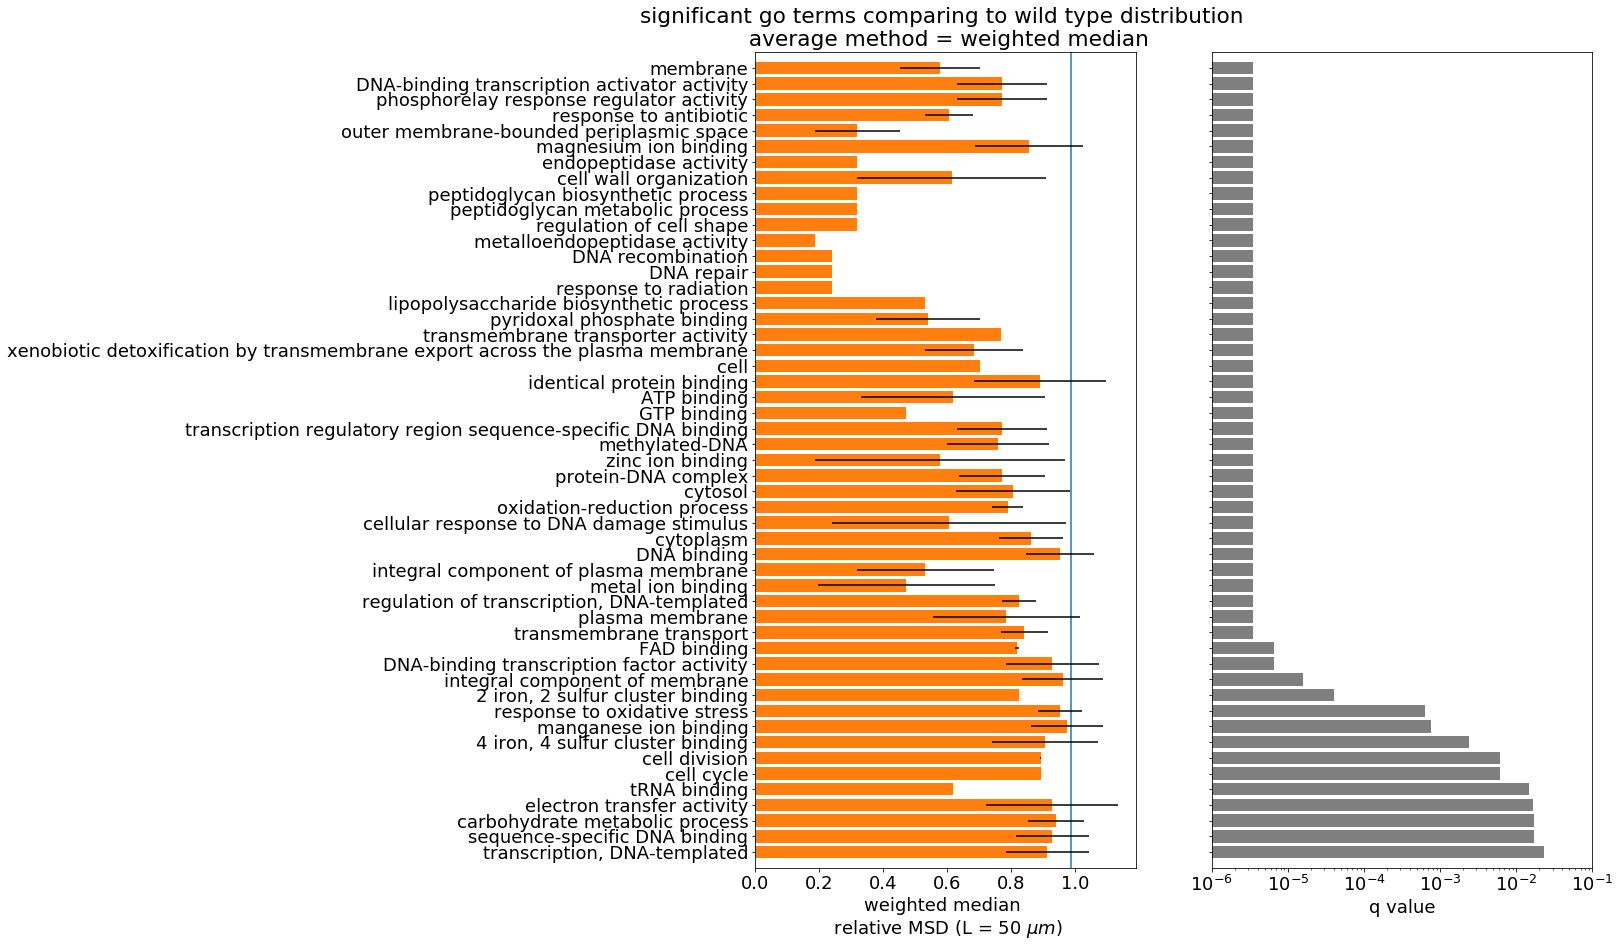

In [26]:
from matplotlib.cm import ScalarMappable
from statsmodels.stats.multitest import multipletests

df_sorted = df_iteration_significances.sort_values('pvalue_iteration0').reset_index(drop = True)

num_terms = len(df_sorted)

df_sorted['pvalue_iteration0'].replace({0:10**-6}, inplace = True) 

pvalues = df_sorted['pvalue_iteration0']
(reject, pvals_corrected, alphacSidak, alphacBonf) =  multipletests(pvalues, method = 'fdr_bh')

pvals_corrected = pvals_corrected * 2

alpha = 0.025

df_sorted_sig = df_sorted[pvals_corrected<alpha]

my_cmap = plt.cm.get_cmap('Greys')
data_color = numpy.log10(pvals_corrected[pvals_corrected<alpha])

data_color_rescaled = data_color - numpy.min(data_color)
data_color_rescaled2 = data_color_rescaled/numpy.max(data_color_rescaled)
colors = my_cmap(data_color_rescaled2)

fig, ax = plt.subplots(1, 2, figsize = (15,15))
b = ax[0].barh(df_sorted_sig.index, df_sorted_sig['weighted_median_msd'], xerr = df_sorted_sig['weighted_mad_msd'], align='center', zorder = 2, color = 'tab:orange')#, color = colors, edgecolor = 'black', alpha = 0.5, zorder = 2)
ax[0].plot([all_average, all_average], [-1, len(df_sorted_sig)], color = 'tab:blue', zorder = 1)
ax[0].set_xlabel('weighted median \n relative MSD (L = 50 $\mu m$)')
ax[0].set_yticks(ticks = df_sorted_sig.index)
ax[0].set_title('significant go terms comparing to wild type distribution \n average method = weighted median')
# df_sorted_sig.loc[df_sorted_sig['go']=='xenobiotic detoxification by transmembrane export across the plasma membrane','go'] = 'xenobiotic detoxification by transmembrane \n export across the plasma membrane'
# print(df_sorted_sig.loc[df_sorted_sig['go']=='xenobiotic detoxification by transmembrane \n export across the plasma membrane','go'])
ax[0].set_yticklabels( labels = df_sorted_sig['go'])
ax[0].set_ylim([-1, len(df_sorted_sig)])
ax[0].invert_yaxis()

# sm = ScalarMappable(cmap=my_cmap, norm=plt.Normalize(min(data_color_rescaled2),max(data_color_rescaled2)))
# sm.set_array([])

# cbar = plt.colorbar(sm)

# alpha_ticks = numpy.log10(numpy.logspace(-6, -2, 5))
# alpha_ticks_rescaled = alpha_ticks-numpy.min(data_color)
# alpha_ticks_rescaled2 = alpha_ticks_rescaled/numpy.max(data_color_rescaled)
# cbar.set_ticks(alpha_ticks_rescaled2)
# print(alpha_ticks_rescaled2)
# print(alpha_ticks)
# # cbar.set_ticklabels([0.4, 0.2, 0.1])
# cbar.set_ticklabels(alpha_ticks)
# cbar.set_label('log(p value)')

# print(df_sorted.index)
# print(df_sorted['pvalue_iteration0']*num_terms)
ax[1].barh(df_sorted_sig.index, pvals_corrected[pvals_corrected<alpha], color = 'k', alpha = 0.5)
ax[1].set_xscale('log')
ax[1].set_xlabel('q value')
ax[1].set_yticks(ticks = df_sorted_sig.index)
ax[1].set_yticklabels(labels = [])
ax[1].set_xlim([10**-6, 10**-1])
ax[1].set_ylim([-1, len(df_sorted_sig)])
ax[1].invert_yaxis()

# plt.savefig('/Users/qinqinyu/Documents/hallatschek_lab/data_changed/20200228_spatial_genetic_drift_summary/figures/significant_go_terms_wmedian_wt_v2.pdf')

In [14]:
df_sorted_sig

,go,go_id,genotypes,wmeans,wmean_stes,n,weighted_median_msd,weighted_mad_msd,pvalue_iteration0
0,membrane,GO:0016020,['ackA' 'cydB' 'yfgC' 'gor' 'mdtF' 'slt' 'fdnG...,[0.57693633 0.41909958 0.18769914 0.926957 1...,[0.05814398 0.06379019 0.05113454 0.15723957 0...,11,0.576936,0.123685,0.000001
1,DNA-binding transcription activator activity,GO:0001216,['rstA' 'basR' 'baeR'],[0.60276095 0.77059387 0.91232223],[0.07883019 0.10662402 0.11199247],3,0.770594,0.141728,0.000001
2,phosphorelay response regulator activity,GO:0000156,['rstA' 'basR' 'baeR'],[0.60276095 0.77059387 0.91232223],[0.07883019 0.10662402 0.11199247],3,0.770594,0.141728,0.000001
3,response to antibiotic,GO:0046677,['basR' 'ydaC' 'ycbB' 'yadC' 'macA' 'mdtF' 'rf...,[0.77059387 1.0410508 1.11024954 1.3323952 0...,[0.10662402 0.15643481 0.14168851 0.34716378 0...,8,0.605214,0.075639,0.000001
4,outer membrane-bounded periplasmic space,GO:0030288,['treA' 'dacA' 'ybaE' 'yfgC' 'slt' 'fdnG'],[1.00003893 0.31908417 0.55699102 0.18769914 1...,[0.12370713 0.05180713 0.08114433 0.05113454 0...,6,0.319084,0.131385,0.000001
5,magnesium ion binding,GO:0000287,['ackA' 'ydaO' 'topB' 'speG' 'thiE' 'otsB' 'yf...,[0.57693633 0.90466688 1.17625973 1.13362205 0...,[0.05814398 0.12469642 0.17836962 0.15211999 0...,8,0.854324,0.169441,0.000001
6,endopeptidase activity,GO:0004175,['dacA' 'ydhO' 'yebA'],[0.31908417 0.83490452 0.79572951],[0.05180713 0.14124693 0.09433711],3,0.319084,0.000000,0.000001
7,cell wall organization,GO:0071555,['dacA' 'ddpX' 'ycbB' 'slt' 'nagZ' 'ydhO' 'yebA'],[0.31908417 0.61337474 1.11024954 1.10298413 0...,[0.05180713 0.07146592 0.14168851 0.13785658 0...,7,0.613375,0.294291,0.000001
8,peptidoglycan biosynthetic process,GO:0009252,['dacA' 'ycbB' 'nagZ'],[0.31908417 1.11024954 0.93970542],[0.05180713 0.14168851 0.16476494],3,0.319084,0.000000,0.000001
9,peptidoglycan metabolic process,GO:0000270,['dacA' 'ydhO' 'yebA'],[0.31908417 0.83490452 0.79572951],[0.05180713 0.14124693 0.09433711],3,0.319084,0.000000,0.000001


In [45]:
df_sorted

,go,go_id,genotypes,wmeans,wmean_stes,n,weighted_median_msd,weighted_mad_msd,pvalue_iteration0
31,membrane,GO:0016020,['ackA' 'cydB' 'yfgC' 'gor' 'mdtF' 'slt' 'fdnG...,[0.57693633 0.41909958 0.18769914 0.926957 1...,[0.05814398 0.06379019 0.05113454 0.15723957 0...,11,0.576936,0.123685,0.000000
27,DNA-binding transcription activator activity,GO:0001216,['rstA' 'basR' 'baeR'],[0.60276095 0.77059387 0.91232223],[0.07883019 0.10662402 0.11199247],3,0.770594,0.141728,0.000000
28,phosphorelay response regulator activity,GO:0000156,['rstA' 'basR' 'baeR'],[0.60276095 0.77059387 0.91232223],[0.07883019 0.10662402 0.11199247],3,0.770594,0.141728,0.000000
29,response to antibiotic,GO:0046677,['basR' 'ydaC' 'ycbB' 'yadC' 'macA' 'mdtF' 'rf...,[0.77059387 1.0410508 1.11024954 1.3323952 0...,[0.10662402 0.15643481 0.14168851 0.34716378 0...,8,0.605214,0.075639,0.000000
30,outer membrane-bounded periplasmic space,GO:0030288,['treA' 'dacA' 'ybaE' 'yfgC' 'slt' 'fdnG'],[1.00003893 0.31908417 0.55699102 0.18769914 1...,[0.12370713 0.05180713 0.08114433 0.05113454 0...,6,0.319084,0.131385,0.000000
32,magnesium ion binding,GO:0000287,['ackA' 'ydaO' 'topB' 'speG' 'thiE' 'otsB' 'yf...,[0.57693633 0.90466688 1.17625973 1.13362205 0...,[0.05814398 0.12469642 0.17836962 0.15211999 0...,8,0.854324,0.169441,0.000000
35,endopeptidase activity,GO:0004175,['dacA' 'ydhO' 'yebA'],[0.31908417 0.83490452 0.79572951],[0.05180713 0.14124693 0.09433711],3,0.319084,0.000000,0.000000
36,cell wall organization,GO:0071555,['dacA' 'ddpX' 'ycbB' 'slt' 'nagZ' 'ydhO' 'yebA'],[0.31908417 0.61337474 1.11024954 1.10298413 0...,[0.05180713 0.07146592 0.14168851 0.13785658 0...,7,0.613375,0.294291,0.000000
37,peptidoglycan biosynthetic process,GO:0009252,['dacA' 'ycbB' 'nagZ'],[0.31908417 1.11024954 0.93970542],[0.05180713 0.14168851 0.16476494],3,0.319084,0.000000,0.000000
38,peptidoglycan metabolic process,GO:0000270,['dacA' 'ydhO' 'yebA'],[0.31908417 0.83490452 0.79572951],[0.05180713 0.14124693 0.09433711],3,0.319084,0.000000,0.000000


In [54]:
# Calculating the colony sizes of ABC transporters
gois = df_kegg[df_kegg['kegg'] == 'ABC transporters']['genotypes'].values[0]
numpy.mean(df_kegg[df_kegg['kegg'] == 'ABC transporters']['wmeans'].values[0])

1.1584689548

In [29]:
df_phenotypes = pd.read_csv('/Users/qinqinyu/Documents/hallatschek_lab/data_changed/20200228_spatial_genetic_drift_summary/all_exp_rel_wmean_replicated_msd_50um_area_roughness_gld_thickness_huang_cell_shape_volume_sa.csv')

In [73]:
df_gois = df_phenotypes[df_phenotypes['genotype'].isin(goi)]
df_gois.columns

Index(['experiment', 'position', 'genotype', 'position in KQY plates', 'wmean',
       'wmean_ste', 'n', 'area', 'area_ste', 'roughness', 'roughness_ste',
       'growth_layer_depth', 'growth_layer_depth_ste', 'thickness',
       'thickness_ste', 'phenotype_n', 'major', 'minor', 'ar', 'std_major',
       'std_minor', 'volume', 'sa'],
      dtype='object')

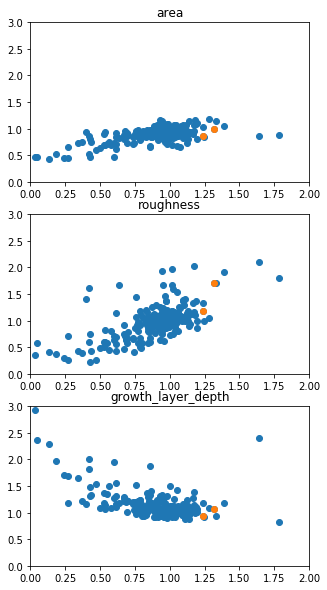

In [78]:
fig, ax = plt.subplots(3,1,figsize = (5,10))

phenotypes = ['area', 'roughness', 'growth_layer_depth']
for i in range(len(phenotypes)):
    ax[i].scatter(df_phenotypes['wmean'], df_phenotypes[phenotypes[i]])
    ax[i].scatter(df_gois['wmean'], df_gois[phenotypes[i]])
    ax[i].set_xlim([0,2])
    ax[i].set_ylim([0,3])
    ax[i].set_title(phenotypes[i])